In [148]:
import os
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras import layers

from tensorflow.keras.layers import Embedding

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import preprocessing
from tensorflow.keras.preprocessing import sequence

from tensorflow.keras import optimizers
from tensorflow.keras import losses

# load IMDB dataset
from tensorflow.keras.datasets import imdb

In [2]:
tf.__version__

'2.4.1'

### One hot encoding

Using Keras for word-level one hot encoding

In [3]:
samples = ['The cat sat on the mat.', 'The dog ate my homework.']

In [5]:
tokenizer = Tokenizer(num_words=1000)
tokenizer.fit_on_texts(samples)

In [6]:
sequences = tokenizer.texts_to_sequences(samples)

In [7]:
sequences

[[1, 2, 3, 4, 1, 5], [1, 6, 7, 8, 9]]

In [8]:
one_hot_results = tokenizer.texts_to_matrix(samples, mode='binary')

In [9]:
one_hot_results

array([[0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]])

In [11]:
word_index = tokenizer.word_index

print('found %s unique tokens' % len(word_index))

found 9 unique tokens


### Word Embedding

Loading the IMDB data for use with an Embedding layer

In [14]:
max_features = 10000
max_len = 20

In [15]:
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/Users/sidparmar/opt/anaconda3/envs/ml/lib/python3.7/site-packages/tensorflow/python/keras/datasets/imdb.py:159: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/Users/sidparmar/opt/anaconda3/envs/ml/lib/python3.7/site-packages/tensorflow/python/keras/datasets/imdb.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) i

In [16]:
x_train = preprocessing.sequence.pad_sequences(x_train, maxlen=max_len)
x_test = preprocessing.sequence.pad_sequences(x_test, maxlen=max_len)

In [20]:
embedding_layer = Embedding(1000, 64)

In [22]:
model = models.Sequential()

model.add(Embedding(10000, 8, input_length=max_len))

model.add(layers.Flatten())

model.add(layers.Dense(1, activation="sigmoid"))

In [23]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

In [24]:
history = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
625/625 [==============================] - 1s 1ms/step - loss: 0.6871 - acc: 0.5631 - val_loss: 0.6320 - val_acc: 0.6958
Epoch 2/10
625/625 [==============================] - 0s 773us/step - loss: 0.5863 - acc: 0.7447 - val_loss: 0.5377 - val_acc: 0.7240
Epoch 3/10
625/625 [==============================] - 0s 759us/step - loss: 0.4769 - acc: 0.7845 - val_loss: 0.5051 - val_acc: 0.7406
Epoch 4/10
625/625 [==============================] - 0s 772us/step - loss: 0.4220 - acc: 0.8141 - val_loss: 0.4960 - val_acc: 0.7474
Epoch 5/10
625/625 [==============================] - 0s 745us/step - loss: 0.3860 - acc: 0.8283 - val_loss: 0.4961 - val_acc: 0.7544
Epoch 6/10
625/625 [==============================] - 0s 781us/step - loss: 0.3633 - acc: 0.8413 - val_loss: 0.5005 - val_acc: 0.7508
Epoch 7/10
625/625 [==============================] - 0s 790us/step - loss: 0.3366 - acc: 0.8590 - val_loss: 0.5068 - val_acc: 0.7496
Epoch 8/10
625/625 [==============================] - 1s 860us/s

74% validation accuracy with just 20 words per review. That's great.

But note that merely flattening the embedded sequences and training a single Dense layer on top leads to a model that treats each word in the input sequence separately, without considering inter-word relationships and sentence structure (for example, this model would likely treat both “this movie is a bomb” and “this movie is the bomb” as being negative reviews). It’s much better to add recurrent layers or 1D convolutional layers on top of the embedded sequences to learn features that take into account each sequence as a whole. 

### from raw text to word embeddings

Processing the labels of the raw IMDB data

In [26]:
imdb_dir = '/Users/sidparmar/workspace-ml/aclImdb'
train_dir = os.path.join(imdb_dir, 'train')

In [27]:
labels = []
texts = []

In [28]:
for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            
            if label_type == 'neg':
                labels.append(0)
                
            else:
                labels.append(1)            

### Tokenizing the data

In [36]:
maxlen = 100
training_samples = 200
validation_samples = 10000
max_words = 10000

In [40]:
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

In [42]:
word_index = tokenizer.word_index
print("Unique words", len(word_index))

Unique words 88582


In [43]:
data = pad_sequences(sequences, maxlen=maxlen)

In [44]:
labels = np.asarray(labels)
print('Shape of data tensor', data.shape)
print('Shape of label tensor', labels.shape)

Shape of data tensor (25000, 100)
Shape of label tensor (25000,)


In [48]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

In [50]:
x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

#### Preprocessing the embeddings

In [51]:
glove_dir = '/Users/sidparmar/workspace-ml/'

In [55]:
embedding_index = {}
f = open(os.path.join(glove_dir, 'glove.42B.300d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embedding_index[word] = coefs
f.close()

In [57]:
print('Founds %s words vecrtor' % len(embedding_index))

Founds 1917494 words vecrtor


Next, you’ll build an embedding matrix that you can load into an Embedding layer. 

In [68]:
embedding_dim = 300

embedding_matrix = np.zeros((max_words, embedding_dim))

In [70]:
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

#### Build model

In [121]:
model = models.Sequential()
model.add(layers.Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(layers.Flatten())
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 100, 300)          3000000   
_________________________________________________________________
flatten_6 (Flatten)          (None, 30000)             0         
_________________________________________________________________
dense_11 (Dense)             (None, 32)                960032    
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 33        
Total params: 3,960,065
Trainable params: 3,960,065
Non-trainable params: 0
_________________________________________________________________


Loading the GloVe embeddings in the model

In [122]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

Compile and train

In [123]:
model.compile(optimizer=optimizers.RMSprop(), 
              loss=losses.binary_crossentropy, 
              metrics=['acc'])

In [124]:
history = model.fit(x_train, y_train, 
                    epochs=10, 
                    batch_size=32, 
                    validation_data=(x_val, y_val))
model.save_weights('pre_trained_glove_model.h5')

Epoch 1/10
7/7 [==============================] - 1s 69ms/step - loss: 1.4273 - acc: 0.4771 - val_loss: 0.7807 - val_acc: 0.4978
Epoch 2/10
7/7 [==============================] - 0s 67ms/step - loss: 0.3316 - acc: 0.8761 - val_loss: 0.6869 - val_acc: 0.5570
Epoch 3/10
7/7 [==============================] - 1s 82ms/step - loss: 0.1803 - acc: 0.9924 - val_loss: 0.7428 - val_acc: 0.5145
Epoch 4/10
7/7 [==============================] - 0s 67ms/step - loss: 0.1260 - acc: 1.0000 - val_loss: 0.6932 - val_acc: 0.5742
Epoch 5/10
7/7 [==============================] - 0s 75ms/step - loss: 0.0462 - acc: 1.0000 - val_loss: 0.7122 - val_acc: 0.5785
Epoch 6/10
7/7 [==============================] - 0s 74ms/step - loss: 0.0229 - acc: 1.0000 - val_loss: 0.7700 - val_acc: 0.5707
Epoch 7/10
7/7 [==============================] - 0s 72ms/step - loss: 0.0102 - acc: 1.0000 - val_loss: 1.0472 - val_acc: 0.5324
Epoch 8/10
7/7 [==============================] - 0s 71ms/step - loss: 0.0077 - acc: 1.0000 - val

Plot loss and accuracy

In [125]:
def plot_loss(loss, val_loss, epochs):
    plt.plot(epochs, loss, 'bo', label="Training Loss")
    plt.plot(epochs, val_loss, 'b', label="Validation Loss")
    
    
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

In [126]:
def plot_acc(acc, val_acc, epochs):
    plt.plot(epochs, acc, 'bo', label="Training Accuracy")
    plt.plot(epochs, val_acc, 'b', label="Validation Accuracy")
    
    
    plt.title('Training and validation Accuracy')
    plt.legend()

    plt.show()

In [127]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

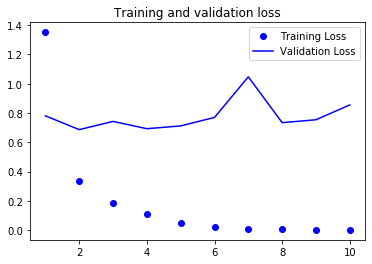

In [128]:
plot_loss(loss, val_loss, epochs)

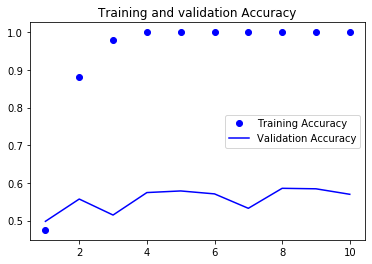

In [129]:
plot_acc(acc, val_acc, epochs)

The model quickly starts overfitting, which is unsurprising given the small number of training samples. Validation accuracy has high variance for the same reason, but it seems to reach the high 50s.

Let's try building a model with out pretrained embedding data. Just 200 samples from training. 

In [130]:
model_without_pre_training = models.Sequential()
model_without_pre_training.add(layers.Embedding(max_words, 100, input_length=maxlen))
model_without_pre_training.add(layers.Flatten())
model_without_pre_training.add(layers.Dense(32, activation='relu'))
model_without_pre_training.add(layers.Dense(1, activation='sigmoid'))
model_without_pre_training.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_7 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_13 (Dense)             (None, 32)                320032    
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


In [131]:
model_without_pre_training.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history_without_pretrained_embedding_data = model_without_pre_training.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))

Epoch 1/10
7/7 [==============================] - 1s 60ms/step - loss: 0.6977 - acc: 0.4084 - val_loss: 0.6918 - val_acc: 0.5209
Epoch 2/10
7/7 [==============================] - 0s 45ms/step - loss: 0.5419 - acc: 0.9730 - val_loss: 0.6933 - val_acc: 0.5160
Epoch 3/10
7/7 [==============================] - 0s 43ms/step - loss: 0.3592 - acc: 0.9981 - val_loss: 0.6937 - val_acc: 0.5284
Epoch 4/10
7/7 [==============================] - 0s 43ms/step - loss: 0.1715 - acc: 0.9950 - val_loss: 0.6996 - val_acc: 0.5246
Epoch 5/10
7/7 [==============================] - 0s 42ms/step - loss: 0.0880 - acc: 1.0000 - val_loss: 0.7032 - val_acc: 0.5330
Epoch 6/10
7/7 [==============================] - 0s 44ms/step - loss: 0.0416 - acc: 1.0000 - val_loss: 0.7080 - val_acc: 0.5297
Epoch 7/10
7/7 [==============================] - 1s 115ms/step - loss: 0.0239 - acc: 1.0000 - val_loss: 0.7161 - val_acc: 0.5306
Epoch 8/10
7/7 [==============================] - 0s 45ms/step - loss: 0.0126 - acc: 1.0000 - va

In [132]:
acc = history_without_pretrained_embedding_data.history['acc']
val_acc = history_without_pretrained_embedding_data.history['val_acc']

loss = history_without_pretrained_embedding_data.history['loss']
val_loss = history_without_pretrained_embedding_data.history['val_loss']

epochs = range(1, len(acc) + 1)

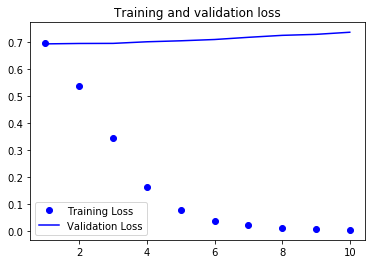

In [133]:
plot_loss(loss, val_loss, epochs)

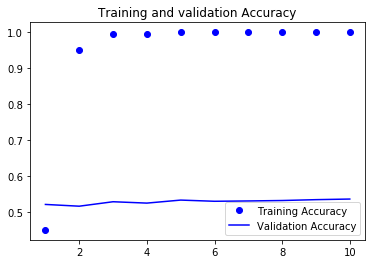

In [134]:
plot_acc(acc, val_acc, epochs)

The model is severely overfitting

#### let’s evaluate the model on the test data. 

Tokenizing the data of the test set

In [135]:
test_dir = os.path.join(imdb_dir, 'test')

In [136]:
labels = []
texts = []

In [137]:
for label_type in ['neg', 'pos']:
    dir_name = os.path.join(test_dir, label_type)
    for fname in sorted(os.listdir(dir_name)):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

In [138]:
sequences = tokenizer.texts_to_sequences(texts)
x_test = pad_sequences(sequences, maxlen=maxlen)
y_test = np.asarray(labels)

In [139]:
model.load_weights('pre_trained_glove_model.h5')
model.evaluate(x_test, y_test)

782/782 [==============================] - 1s 1ms/step - loss: 0.8722 - acc: 0.5602


[0.8721513152122498, 0.5601999759674072]

Got 56% accuracy working with just 200 samples. 

Adding more samples can decrease overfitting and increase accuracy.

# RNN

In [144]:
tf.keras.backend.clear_session()

Pre processing data

In [145]:
max_features = 10000
maxlen = 500
batch_size = 32

In [146]:
print('Loading Data...')
(input_train, y_train), (input_test, y_test) = imdb.load_data(num_words=max_features)

print(len(input_train), 'train sequence')
print(len(input_test), 'test sequence')

Loading Data...


<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/Users/sidparmar/opt/anaconda3/envs/ml/lib/python3.7/site-packages/tensorflow/python/keras/datasets/imdb.py:159: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])


25000 train sequence
25000 test sequence


/Users/sidparmar/opt/anaconda3/envs/ml/lib/python3.7/site-packages/tensorflow/python/keras/datasets/imdb.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])


In [149]:
print('Pad sequences (samples X times)')
input_train = sequence.pad_sequences(input_train, maxlen=maxlen)
input_test = sequence.pad_sequences(input_test, maxlen=maxlen)

print('input_train shape', input_train.shape)
print('input_test shape', input_test.shape)

Pad sequences (samples X times)
input_train shape (25000, 500)
input_test shape (25000, 500)


### SimpleRNN

In [150]:
model_with_simple_RNN = models.Sequential()
model_with_simple_RNN.add(layers.Embedding(max_features, 32))
model_with_simple_RNN.add(layers.SimpleRNN(32))
model_with_simple_RNN.add(layers.Dense(1, activation='sigmoid'))

In [151]:
model_with_simple_RNN.compile(loss=losses.binary_crossentropy, 
                              optimizer=optimizers.RMSprop(), 
                              metrics=['acc'])

In [152]:
history_with_simple_RNN = model_with_simple_RNN.fit(input_train, y_train, 
                                                    epochs=10, 
                                                    batch_size=128, 
                                                    validation_split=0.2)

Epoch 1/10
157/157 [==============================] - 14s 85ms/step - loss: 0.6797 - acc: 0.5561 - val_loss: 0.6104 - val_acc: 0.6634
Epoch 2/10
157/157 [==============================] - 13s 83ms/step - loss: 0.4478 - acc: 0.8009 - val_loss: 0.3900 - val_acc: 0.8382
Epoch 3/10
157/157 [==============================] - 13s 83ms/step - loss: 0.2988 - acc: 0.8850 - val_loss: 1.0586 - val_acc: 0.6206
Epoch 4/10
157/157 [==============================] - 14s 89ms/step - loss: 0.2697 - acc: 0.8937 - val_loss: 0.3913 - val_acc: 0.8472
Epoch 5/10
157/157 [==============================] - 14s 89ms/step - loss: 0.1570 - acc: 0.9465 - val_loss: 0.3917 - val_acc: 0.8526
Epoch 6/10
157/157 [==============================] - 13s 85ms/step - loss: 0.1158 - acc: 0.9603 - val_loss: 0.4775 - val_acc: 0.8142
Epoch 7/10
157/157 [==============================] - 13s 85ms/step - loss: 0.0700 - acc: 0.9785 - val_loss: 0.5634 - val_acc: 0.7582
Epoch 8/10
157/157 [==============================] - 13s 81ms

In [153]:
acc = history_with_simple_RNN.history['acc']
val_acc = history_with_simple_RNN.history['val_acc']

loss = history_with_simple_RNN.history['loss']
val_loss = history_with_simple_RNN.history['val_loss']

epochs = range(1, len(acc) + 1)

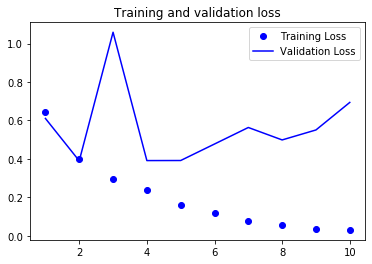

In [154]:
plot_loss(loss, val_loss, epochs)

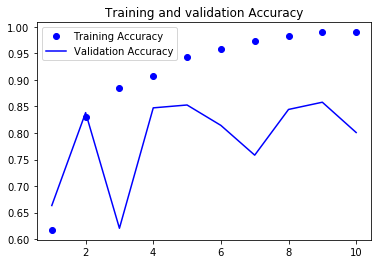

In [155]:
plot_acc(acc, val_acc, epochs)

As a reminder, in chapter 3, the first naive approach to this dataset got you to a test accuracy of 88%. Unfortunately, this small recurrent network doesn’t perform well compared to this baseline (only 80% validation accuracy). Part of the problem is that your inputs only consider the first 500 words, rather than full sequences—hence, the RNN has access to less information than the earlier baseline model. The remainder of the problem is that SimpleRNN isn’t good at processing long sequences, such as text. Other types of recurrent layers perform much better. 